In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from model.resnet import ResNet18
from model.resnext import CifarResNeXt
from model.wrn import WideResNet
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim
from torchsummary import summary

In [2]:
resnet18 = ResNet18() # student model
resnext = CifarResNeXt(cardinality=8, depth=29, num_classes=10)

wrn = WideResNet(depth=28, num_classes=10, widen_factor=10, dropRate=0.3)

resnet18.load_state_dict(torch.load('./experiments/resnet18_distill/resnext_teacher/best.pth.tar', map_location='cpu')['state_dict'])


state_dict = torch.load('./experiments/base_wrn/best.pth.tar', map_location='cpu')['state_dict']
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
wrn.load_state_dict(new_state_dict)


state_dict = torch.load('./experiments/base_resnext29/best.pth.tar', map_location='cpu')['state_dict']
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
resnext.load_state_dict(new_state_dict)

/Users/aayush/Code_Shits/knowledge-distillation-pytorch/model/resnext.py:82: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.classifier.weight)
/Users/aayush/Code_Shits/knowledge-distillation-pytorch/model/resnext.py:87: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.state_dict()[key], mode='fan_out')


<All keys matched successfully>

In [3]:
train_transformer = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
        ])

trainset = torchvision.datasets.CIFAR10(root='./data-cifar10', train=True, download=True, transform=train_transformer)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True)

Files already downloaded and verified


In [4]:
train_batch, labels_batch = next(iter(trainloader))
print(train_batch.shape, labels_batch)

torch.Size([5, 3, 32, 32]) tensor([7, 8, 1, 0, 6])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


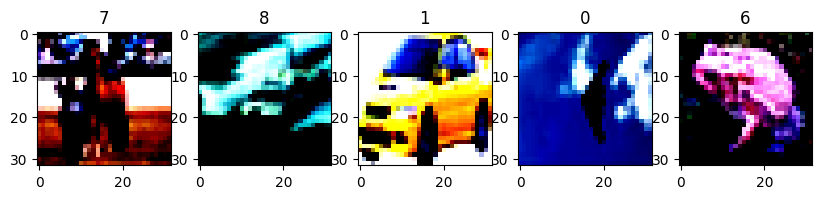

In [5]:
fig, ax = plt.subplots(1, train_batch.shape[0], figsize=(10, 10))
for i in range(train_batch.shape[0]):
    ax[i].imshow(train_batch[i].numpy().transpose(1, 2, 0))
    ax[i].set_title(labels_batch[i].item())

In [6]:
# for name, param in wrn.named_parameters():
#     print(name, param.shape)

In [7]:
# import torchvision.models as models
# model = models.resnet50(pretrained=True)
# # print(model.layer4)

# for name, param in model.named_parameters():
#     print(name, param.shape)

In [8]:
# these are the weights we will use for class activation mapping
fc_params = torch.tensor([])
for name, param in resnet18.named_parameters():
    # print(name, param.shape)
    if name == 'linear.weight':
        fc_params = param
        print(name, param.shape)


# these are the weights we will use for class activation mapping
fc_params_teacher = torch.tensor([])
for name, param in wrn.named_parameters():
    # print(name, param.shape)
    if name == 'fc.weight':
        fc_params_teacher = param
        print(name, param.shape)

linear.weight torch.Size([10, 512])
fc.weight torch.Size([10, 640])


In [9]:
# print(wrn.relu)

In [10]:
# register forward hook to get the 7 X 7 X 2048 output before the average pooling layer
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# adding forward hook to the penultimate relu layer
resnet18.layer4[1].shortcut.register_forward_hook(get_activation('shortcut'))
wrn.relu.register_forward_hook(get_activation('relu'))
# resnet18.layer4[2].relu.register_forward_hook(get_activation('relu'))

In [11]:
def get_weighted_CAM(forward_hooked_model, index, weights, student = True, rescale=True):
    # print(weights.shape)

    if student:
        key = 'shortcut'
        layer_size = 512
        resize_val = 4
    else:
        key = 'relu'
        layer_size = 640
        resize_val = 8
    _ = forward_hooked_model(torch.unsqueeze(train_batch[index], 0))
    activation[key] = activation[key][0]
    activation[key] = activation[key].permute(1, 2, 0)
    # 7 X 7 X 2048 => 49 X 2048
    activation[key] = activation[key].reshape(-1, layer_size)

    # class_index = actual_labels_indices[index]
    # weighted sum of the 2048 class activation maps
    activation_map = torch.matmul(activation[key], weights) # 49 X 1
    activation_map = activation_map.reshape(resize_val, resize_val)
    
    if rescale:
        # activation_map = torch.nn.functional.relu(activation_map)
        activation_map = activation_map - torch.min(activation_map)
        activation_map = activation_map / (torch.max(activation_map) - torch.min(activation_map))
        activation_map = activation_map * 255

    return activation_map

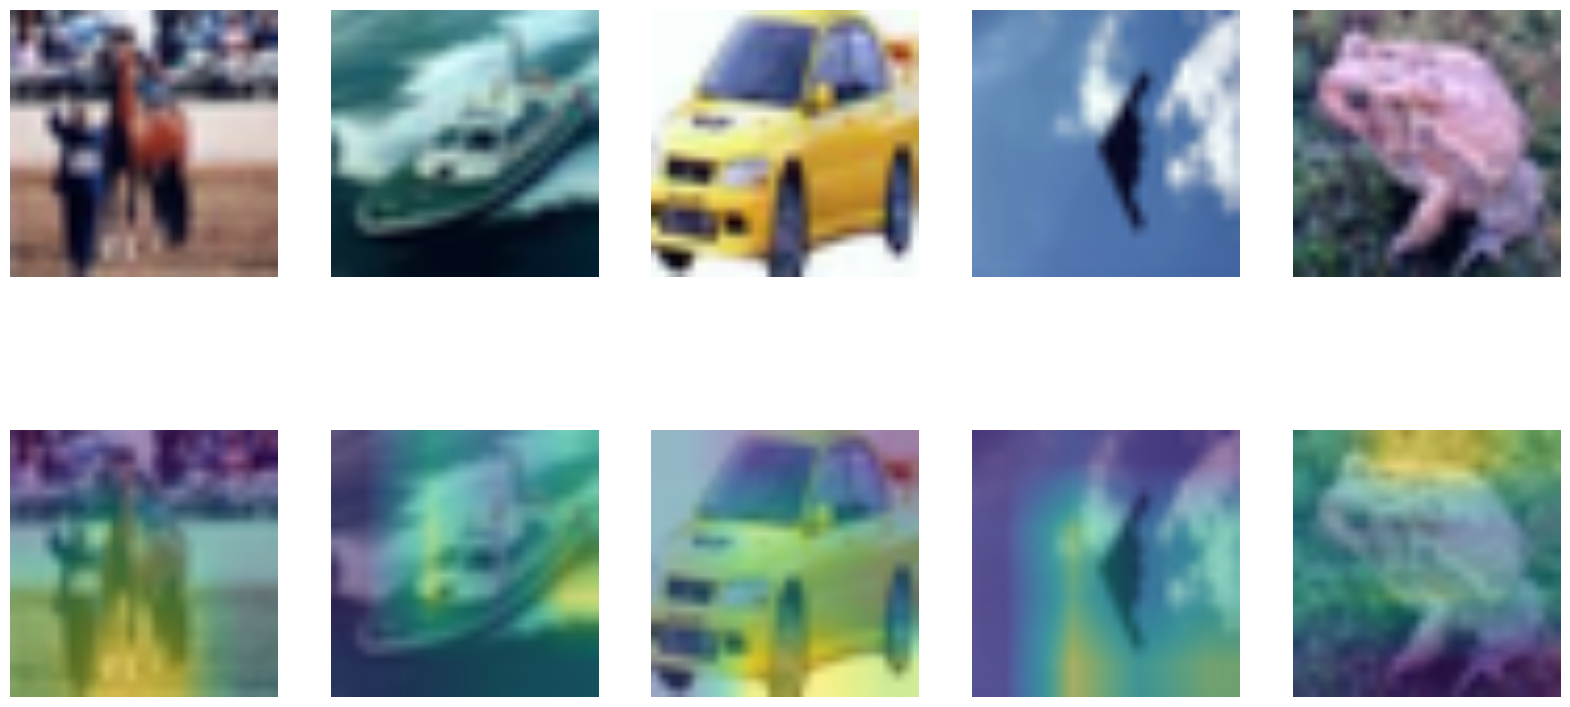

In [12]:
fig, axes = plt.subplots(2, train_batch.shape[0], figsize=(20, 10))
activation_maps_student = []

for i in range(train_batch.shape[0]):  
    activation_map = get_weighted_CAM(resnet18, i, fc_params[labels_batch[i]])

    activation_map = activation_map.detach().numpy().astype(np.uint8)
    print

    activation_map = cv2.resize(activation_map, (224, 224))
    # activation_maps_student.append(activation_map)
    activation_map = cv2.applyColorMap(activation_map, cv2.COLORMAP_VIRIDIS)
    activation_map = cv2.cvtColor(activation_map, cv2.COLOR_BGR2RGB)
    # original_image = cv2.imread('/Users/aayush/Desktop/AAYUSH/COLLEGE/SEMESTERS/SEMESTER 6/AI5100/Assignments/Assignment 3/images/i1.jpg')
    original_image = train_batch[i].numpy().transpose(1, 2, 0)
    original_image = original_image - np.min(original_image)
    original_image = original_image / np.max(original_image)
    original_image = original_image * 255
    original_image = original_image.astype(np.uint8)
    original_image = cv2.resize(original_image, (224, 224))

    activation_maps_student.append(activation_map)
    activation_map = cv2.addWeighted(original_image, 0.5, activation_map, 0.5, 0)

    # activation_maps_teacher.append(activation_map)

    axes[0][i].imshow(original_image)
    axes[0][i].axis('off')
    axes[1][i].imshow(activation_map)
    axes[1][i].axis('off')

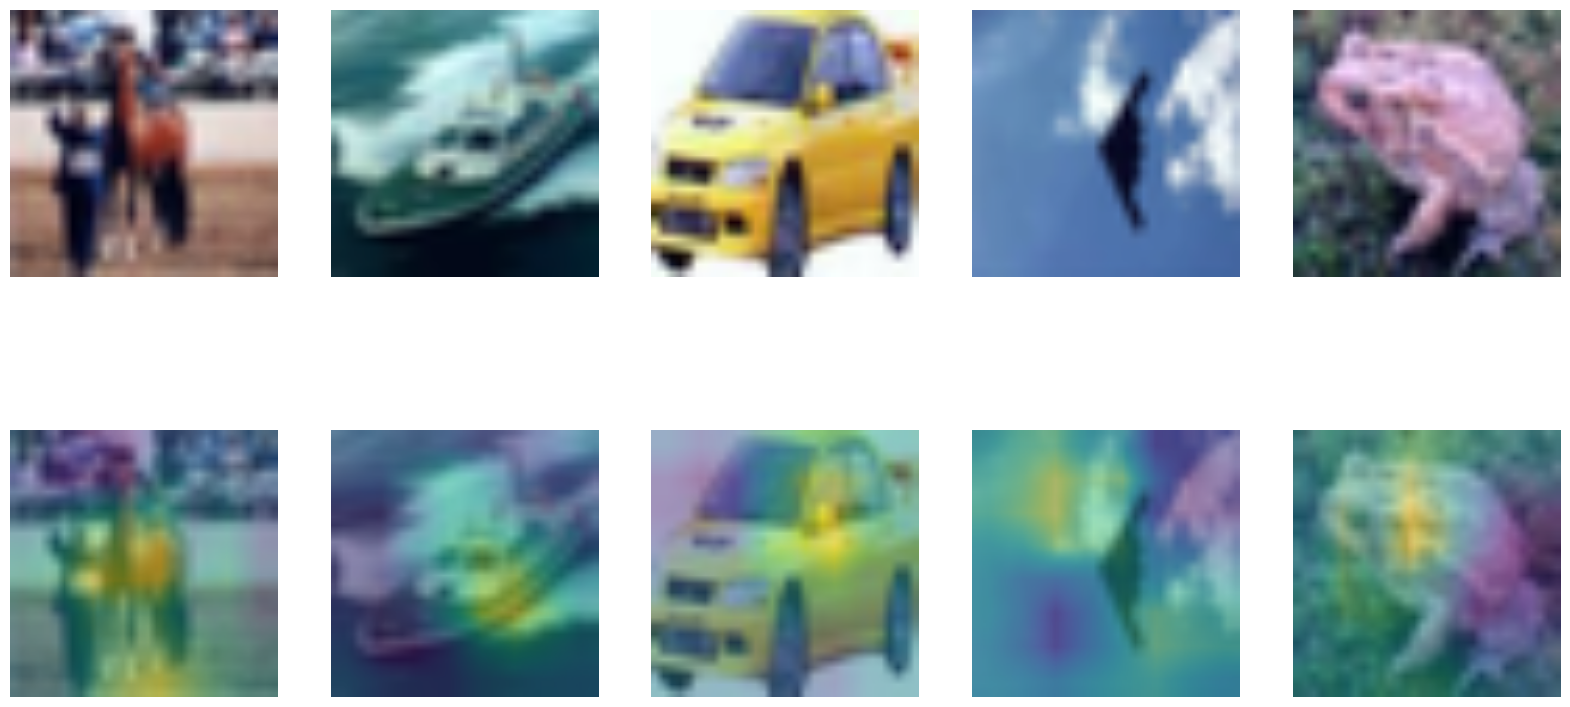

In [13]:
fig, axes = plt.subplots(2, train_batch.shape[0], figsize=(20, 10))
activation_maps_teacher = []

for i in range(train_batch.shape[0]):  
    activation_map = get_weighted_CAM(wrn, i, fc_params_teacher[labels_batch[i]], student=False)

    activation_map = activation_map.detach().numpy().astype(np.uint8)
    # print(activation_map.shape)

    activation_map = cv2.resize(activation_map, (224, 224))
    # activation_maps_teacher.append(activation_map)
    activation_map = cv2.applyColorMap(activation_map, cv2.COLORMAP_VIRIDIS)
    activation_map = cv2.cvtColor(activation_map, cv2.COLOR_BGR2RGB)
    # original_image = cv2.imread('/Users/aayush/Desktop/AAYUSH/COLLEGE/SEMESTERS/SEMESTER 6/AI5100/Assignments/Assignment 3/images/i1.jpg')
    original_image = train_batch[i].numpy().transpose(1, 2, 0)
    original_image = original_image - np.min(original_image)
    original_image = original_image / np.max(original_image)
    original_image = original_image * 255
    original_image = original_image.astype(np.uint8)

    original_image = cv2.resize(original_image, (224, 224))

    activation_maps_teacher.append(activation_map)
    activation_map = cv2.addWeighted(original_image, 0.5, activation_map, 0.5, 0)

    # activation_maps_teacher.append(activation_map)
    # print(activation_map.shape)

    axes[0][i].imshow(original_image)
    axes[0][i].axis('off')
    axes[1][i].imshow(activation_map)
    axes[1][i].axis('off')

In [14]:
print(activation_maps_student[0].shape, activation_maps_teacher[0].shape)

(224, 224, 3) (224, 224, 3)


In [15]:
ssim_vals = []
for i in range(len(activation_maps_student)):
    ssim_vals.append(ssim(activation_maps_student[i], activation_maps_teacher[i], multichannel=True, channel_axis=2))
    # ssim_vals.append(ssim(activation_maps_student[i], activation_maps_teacher[i]))
print("Mean SSIM values for the Class Activation Maps = ", np.mean(ssim_vals))

Mean SSIM values for the Class Activation Maps =  0.6717598649795414


In [16]:
summary(resnet18, (3, 32, 32))
summary(wrn, (3, 32, 32))
summary(resnext, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,